In [1]:
%load_ext autoreload
%autoreload 2    

In [2]:
import os
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time
import pandas as pd 
import matplotlib.pyplot as plt
from IPython.display import clear_output
import cv2
import torchmetrics

import albumentations as A
from albumentations.pytorch import ToTensorV2


In [3]:
import numpy as np
# ! pip install opencv-python==4.5.5.64
import cv2 

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
batch_size = 8

# Custom loss

In [6]:
#PyTorch
ALPHA = 0.8
GAMMA = 2

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer    
        inputs = F.sigmoid(inputs)
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs.to(float), targets.to(float), reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

# Augmentation

In [7]:
def visualize_img_and_label():

    
    plt.figure(figsize=(10, 4))
    for i in range(5):
        im, lb = trainset.__getitem__(i)
        plt.subplot(2, 5, i+1)
        plt.imshow(im.permute(1,2,0))
        plt.xticks([])
        plt.yticks([])
        plt.subplot(2, 5, 6+i)
        plt.imshow(lb) # lab.permute(1,2,0)
        plt.xticks([])
        plt.yticks([])
        plt.subplots_adjust(hspace=0, wspace=0)
    plt.show()

In [8]:
from data_loader import PH2, DRIVE

In [9]:
size = 128

train_transform = A.Compose(
    [
        A.Resize(size, size),
        A.Rotate(limit=90, p=1, border_mode=cv2.BORDER_CONSTANT),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        #A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.GaussNoise(p=0.5),
        A.Flip(p=0.5),
        A.Normalize(),
        ToTensorV2(),
        
    ]
)

test_transform = A.Compose([A.Resize(size, size), 
                            A.Normalize(),
                            ToTensorV2()])




In [10]:
trainset = PH2('train', transform=test_transform) # test_transform for no augment
valset = PH2('val', transform=test_transform)
testset = PH2('test', transform=test_transform)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8,)# persistent_workers=True, pin_memory=True)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=8,)# persistent_workers=True, pin_memory=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8,)# persistent_workers=True, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


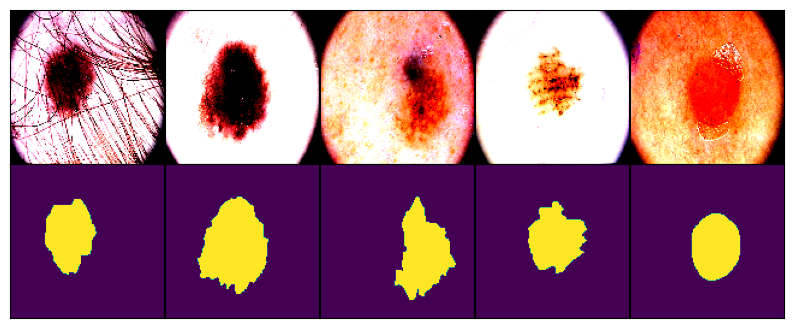

In [11]:
visualize_img_and_label()

# Model

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.enc_conv3 = nn.Conv2d(64, 1, 3, padding=1)
        
    def forward(self, x):
        # encoder
        e0 = F.relu(self.enc_conv0(x))
        e1 = F.relu(self.enc_conv1(e0))
        e2 = F.relu(self.enc_conv2(e1))

        # no activation
        e3 = self.enc_conv3(e2)
        
        return e3

# Train

In [10]:
import torch
from torchmetrics import Metric

class Sensitivity(torchmetrics.Metric):
    def __init__(self, dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        self.add_state("tp", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("fn", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        # Convert predictions to binary values (0 or 1)
        preds = torch.round(preds)

        # Calculate true positives and false negatives
        tp = torch.sum((preds >= 0.5) & (target == 1))
        fn = torch.sum((preds < 0.5) & (target == 1))

        # Update state variables
        self.tp += tp
        self.fn += fn

    def compute(self):
        # Calculate sensitivity/recall
        sensitivity = self.tp.float() / (self.tp + self.fn + 1e-12)

        return sensitivity

In [11]:
def train(model, opt, loss_fn, epochs, train_loader, val_loader, test_loader):

    train_loss = []
    val_loss = []


    metric_dict = {
                'train_dice': torchmetrics.Dice().to(device),
                'train_iou': torchmetrics.JaccardIndex('binary').to(device),
                'train_acc': torchmetrics.Accuracy('binary').to(device),
                'train_sens': Sensitivity().to(device),
                'train_spec': torchmetrics.Specificity('binary').to(device),
                
                'val_dice': torchmetrics.Dice().to(device),
                'val_iou': torchmetrics.JaccardIndex('binary').to(device),
                'val_acc': torchmetrics.Accuracy('binary').to(device),
                'val_sens': Sensitivity().to(device),
                'val_spec': torchmetrics.Specificity('binary').to(device),

                                
                'test_dice': torchmetrics.Dice().to(device),
                'test_iou': torchmetrics.JaccardIndex('binary').to(device),
                'test_acc': torchmetrics.Accuracy('binary').to(device),
                'test_sens': Sensitivity().to(device),
                'test_spec': torchmetrics.Specificity('binary').to(device),
               }

    out_dict = {
                
                'train_loss':[],
                'train_dice': [],
                'train_iou': [],
                'train_acc': [],
                'train_sens': [],
                'train_spec': [],

                'val_loss':[],
                'val_dice': [],
                'val_iou':[],
                'val_acc': [],
                'val_sens': [],
                'val_spec': [],

                                
                'test_dice': [],
                'test_iou': [],
                'test_acc': [],
                'test_sens': [],
                'test_spec': [],
    }

    
    for epoch in range(epochs):
        tic = time()
        
        avg_loss = 0
        avg_loss_val = 0
        
        model.train()  # train mode
        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            Y_batch = Y_batch.unsqueeze(1)
            loss = loss_fn(F.sigmoid(Y_pred), Y_batch)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(train_loader)

            metric_dict['train_dice'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['train_acc'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['train_iou'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['train_sens'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['train_spec'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))

            
        toc = time()

        model.eval()  # testing mode
        for X_batch, Y_batch in val_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            
            Y_pred = model(X_batch)
            Y_batch = Y_batch.unsqueeze(1)
            loss_test = loss_fn(Y_pred, Y_batch)  # forward-pass
            avg_loss_val += loss / len(val_loader)

            metric_dict['val_dice'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['val_acc'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['val_iou'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['val_sens'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['val_spec'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            
        
        train_loss.append(avg_loss.detach().cpu())
        val_loss.append(avg_loss_val.detach().cpu())

        #plt.plot(train_loss, np.arange(len(train_loss)))
        #plt.plot(test_loss, np.arange(len(test_loss)))
                 
        for metric in ['dice', 'acc', 'iou', 'sens', 'spec']:
            out_dict['train_' + metric].append(metric_dict['train_' + metric].compute().detach().cpu())
            out_dict['val_' + metric].append(metric_dict['val_' + metric].compute().detach().cpu())

        
        print(f"Loss train: {avg_loss:.3f}\t Val Acc: {metric_dict['val_acc'].compute():.3f}\t, Val Dice: {metric_dict['val_dice'].compute()}")

    model.eval()  # testing mode
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        
        Y_pred = model(X_batch)
        Y_batch = Y_batch.unsqueeze(1)

        metric_dict['test_dice'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
        metric_dict['test_acc'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
        metric_dict['test_iou'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
        metric_dict['test_sens'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
        metric_dict['test_spec'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))

    for metric in ['dice', 'acc', 'iou', 'sens', 'spec']:
        out_dict['test_' + metric].append(metric_dict['test_' + metric].compute().detach().cpu())

    out_dict['train_loss'] = train_loss
    out_dict['val_loss'] = val_loss
    
    
    return out_dict, metric_dict


    
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [F.sigmoid(model(X_batch.to(device))) for X_batch, _ in data]
    return np.array(Y_pred)

In [15]:
model = SimpleCNN().to(device)
loss_fn = FocalLoss()

In [16]:
out_dict, metric_dict = train(model, optim.Adam(model.parameters(), 0.001), loss_fn, 100, train_loader, val_loader, test_loader)

Loss train: 0.147	 Val Acc: 0.811	, Val Dice: 0.7228423357009888
Loss train: 0.117	 Val Acc: 0.813	, Val Dice: 0.7346982359886169
Loss train: 0.117	 Val Acc: 0.805	, Val Dice: 0.7091382741928101
Loss train: 0.114	 Val Acc: 0.808	, Val Dice: 0.7168431878089905
Loss train: 0.115	 Val Acc: 0.808	, Val Dice: 0.7136236429214478
Loss train: 0.114	 Val Acc: 0.808	, Val Dice: 0.713051438331604
Loss train: 0.113	 Val Acc: 0.809	, Val Dice: 0.7148646712303162
Loss train: 0.112	 Val Acc: 0.810	, Val Dice: 0.7159813642501831
Loss train: 0.112	 Val Acc: 0.811	, Val Dice: 0.7173061966896057
Loss train: 0.110	 Val Acc: 0.812	, Val Dice: 0.7190253138542175
Loss train: 0.110	 Val Acc: 0.812	, Val Dice: 0.7185794711112976
Loss train: 0.110	 Val Acc: 0.814	, Val Dice: 0.7210418581962585
Loss train: 0.109	 Val Acc: 0.815	, Val Dice: 0.7236797213554382
Loss train: 0.108	 Val Acc: 0.816	, Val Dice: 0.7276843786239624
Loss train: 0.107	 Val Acc: 0.818	, Val Dice: 0.7307400107383728
Loss train: 0.107	 Val Acc

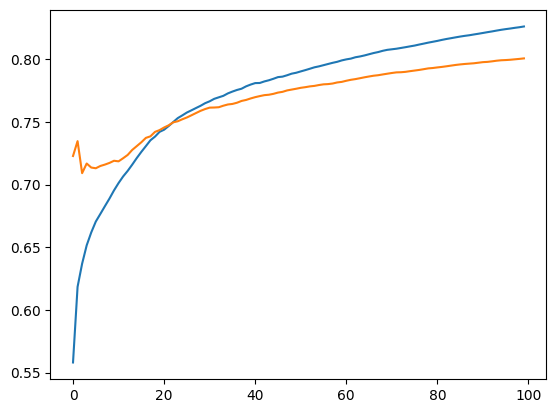

In [17]:
plt.plot(np.arange(len(out_dict['train_dice'])), np.array(out_dict['train_dice'])) 
plt.plot(np.arange(len(out_dict['val_dice'])), np.array(out_dict['val_dice'])) 


In [18]:
out_dict['test_dice'] = np.repeat(out_dict['test_dice'], len(out_dict['train_dice']))
out_dict['test_iou'] = np.repeat(out_dict['test_iou'], len(out_dict['train_dice']))
out_dict['test_acc'] = np.repeat(out_dict['test_acc'], len(out_dict['train_dice']))
out_dict['test_sens'] = np.repeat(out_dict['test_sens'], len(out_dict['train_dice']))
out_dict['test_spec'] = np.repeat(out_dict['test_spec'], len(out_dict['train_dice']))


In [19]:
pd.DataFrame(out_dict).astype(float).to_csv('results/Simple_CNN_ADAM_Augment_FocalLoss')

In [20]:
out_dict['test_dice']

array([0.8523982, 0.8523982, 0.8523982, 0.8523982, 0.8523982, 0.8523982,
       0.8523982, 0.8523982, 0.8523982, 0.8523982, 0.8523982, 0.8523982,
       0.8523982, 0.8523982, 0.8523982, 0.8523982, 0.8523982, 0.8523982,
       0.8523982, 0.8523982, 0.8523982, 0.8523982, 0.8523982, 0.8523982,
       0.8523982, 0.8523982, 0.8523982, 0.8523982, 0.8523982, 0.8523982,
       0.8523982, 0.8523982, 0.8523982, 0.8523982, 0.8523982, 0.8523982,
       0.8523982, 0.8523982, 0.8523982, 0.8523982, 0.8523982, 0.8523982,
       0.8523982, 0.8523982, 0.8523982, 0.8523982, 0.8523982, 0.8523982,
       0.8523982, 0.8523982, 0.8523982, 0.8523982, 0.8523982, 0.8523982,
       0.8523982, 0.8523982, 0.8523982, 0.8523982, 0.8523982, 0.8523982,
       0.8523982, 0.8523982, 0.8523982, 0.8523982, 0.8523982, 0.8523982,
       0.8523982, 0.8523982, 0.8523982, 0.8523982, 0.8523982, 0.8523982,
       0.8523982, 0.8523982, 0.8523982, 0.8523982, 0.8523982, 0.8523982,
       0.8523982, 0.8523982, 0.8523982, 0.8523982, 

In [21]:
# 0.855 benchmark